**Source: IBM GPXX04XJEN
SPAM classification task in Cybersecurity**

Melakukan proses deteksi pesan SPAM dengan menerapkan modeling (Machine Learning dan Deep Learning) menggunakan interface NLP dan Network Security

Tujuan lain yang akan dicapai adalah:
1. membangun model klasifikasi terbaik dan cepat dalam kumpulan data SMS Spam Collection dengan pekerjaan interface model layer-by-layer.
2. membuat laporan metrics dan performa dari evaluasi model.
3. meningkatkan metrics dan performa model dan testing model dengan fine-tune hyperparameter dalam menghasilkan model prediksi yang sesuai dan hasil lebi baik.
4. membuat sebuah hasil report visual guna melihat sebuah insight dan hasil analisis dari data yang di olah.

In [1]:
from IPython.display import Image, HTML, display, display_html
source_tautan = "https://skills.network/logos/SN_web_lightmode.png"
HTML(f'<div style="text-align: center;"><img src="{source_tautan}" style="max-width: 520px; height: auto;"></div>')

**Downloading Data**

In [ ]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/Advanced_ML_DL_spam_classification_L4/spam.csv

--2024-09-14 14:42:10--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/Advanced_ML_DL_spam_classification_L4/spam.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv.4’

spam.csv.4          100%[===================>] 491.86K  --.-KB/s    in 0.08s   

2024-09-14 14:42:11 (5.88 MB/s) - ‘spam.csv.4’ saved [503663/503663]



In [ ]:
!pip install nltk
!pip install wordcloud
!pip install tensorflow==3.10.14

ERROR: Could not find a version that satisfies the requirement tensorflow==3.10.14 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0)
ERROR: No matching distribution found for tensorflow==3.10.14


In [ ]:
import nltk, re, collections, pickle, os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# NLP
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

# Machine Learning Algorithm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Dropout, Bidirectional
from tensorflow.keras.models import Model, Sequential



from logging import warning
plt.rcParams['figure.figsize'] = (15,5)
plt.style.use('ggplot')
seed = 30

import warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter(action='ignore', category=Warning)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
pd.set_option("display.precision", 3)
pd.options.display.float_format = '{:.3f}'.format

In [ ]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'accuracy' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'accuracy' in s and 'val' in s]

    plt.figure(figsize = (12, 5), dpi = 100)
    COLOR = 'gray'
    plt.rc('legend', fontsize = 14)
    plt.rc('figure', titlesize = 12)

    if len(loss_list) == 0:
        print('Loss is missing in history')
        return
    epochs = range(1, len(history.history[loss_list[0]]) + 1)


    ## Loss
    plt.subplot(1, 2, 1)
    plt.subplots_adjust(wspace = 2, hspace = 2)
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.titlecolor'] = 'black'
    plt.rcParams['axes.labelcolor'] = COLOR
    plt.rcParams['xtick.color'] = COLOR
    plt.rcParams['ytick.color'] = COLOR
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b-o',
                 label = 'Train (' + str(str(format(history.history[l][-1],'.4f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g',
                 label = 'Valid (' + str(str(format(history.history[l][-1],'.4f'))+')'))
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend(facecolor = 'gray', loc = 'best')
    plt.grid(True)
    plt.tight_layout()


    ## Accuracy
    plt.subplot(1, 2, 2)
    plt.subplots_adjust(wspace = 2, hspace = 2)
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.titlecolor'] = 'black'
    plt.rcParams['axes.labelcolor'] = COLOR
    plt.rcParams['xtick.color'] = COLOR
    plt.rcParams['ytick.color'] = COLOR
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b-o',
                 label = 'Train (' + str(format(history.history[l][-1],'.4f'))+')')
    for l in val_acc_list:
        plt.plot(epochs, history.history[l], 'g',
                 label = 'Valid (' + str(format(history.history[l][-1],'.4f'))+')')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(facecolor = 'gray', loc = 'best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_conf_matr(conf_matr, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.winter):
  import itertools

  accuracy = np.trace(conf_matr) / np.sum(conf_matr).astype('float')
  sns.set(font_scale = 1.4)

  plt.figure(figsize = (12, 8))
  plt.imshow(conf_matr, interpolation = 'nearest', cmap = cmap)
  title = '\n' + title + '\n'
  plt.title(title)
  plt.colorbar()

  if classes is not None:
      tick_marks = np.arange(len(classes))
      plt.xticks(tick_marks, classes, rotation = 45)
      plt.yticks(tick_marks, classes)

  if normalize:
      conf_matr = conf_matr.astype('float') / conf_matr.sum(axis = 1)[:, np.newaxis]


  thresh = conf_matr.max() / 1.5 if normalize else conf_matr.max() / 2
  for i, j in itertools.product(range(conf_matr.shape[0]), range(conf_matr.shape[1])):
      if normalize:
          plt.text(j, i, "{:0.2f}%".format(conf_matr[i, j] * 100),
                    horizontalalignment = "center",
                    fontweight = 'bold',
                    color = "white" if conf_matr[i, j] > thresh else "black")
      else:
          plt.text(j, i, "{:,}".format(conf_matr[i, j]),
                    horizontalalignment = "center",
                    fontweight = 'bold',
                    color = "white" if conf_matr[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label\n\nAccuracy = {:0.2f}%; Error = {:0.2f}%'.format(accuracy * 100, (1 - accuracy) * 100))
  plt.show()


def plot_words(set, number):
  words_counter = collections.Counter([word for sentence in set for word in sentence.split()])
  most_counted = words_counter.most_common(number)
  most_count = pd.DataFrame(most_counted, columns = ["Words", "Amount"]).sort_values(by = "Amount")
  most_count.plot.barh(x = "Words",
                       y = "Amount",
                       color = "blue",
                       figsize = (10, 15))
  for i, v in enumerate(most_count["Amount"]):
    plt.text(v, i,
             " " + str(v),
             color = 'black',
             va = 'center',
             fontweight = 'bold')

def word_cloud(tag):
  df_words_nl = ' '.join(list(df_spam[df_spam['feature'] == tag]['message']))
  df_wc_nl = WordCloud(width = 600, height = 512).generate(df_words_nl)
  plt.figure(figsize = (13, 9), facecolor = 'k')
  plt.imshow(df_wc_nl)
  plt.axis('off')
  plt.tight_layout(pad = 1)
  plt.show()

**Data Manipulation and EDA**

In [ ]:
df_spam = pd.read_csv('/content/spam.csv', encoding='latin-1')
df_spam

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [ ]:
df_spam = df_spam.filter(['v1', 'v2'], axis = 1)
df_spam.columns = ['feature', 'message']
df_spam.drop_duplicates(inplace = True, ignore_index = True)
print('Number of null values:\n')
df_spam.isnull().sum()

Number of null values:



,0
feature,0
message,0


In [ ]:
df_spam

,feature,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5164,spam,This is the 2nd time we have tried 2 contact u...
5165,ham,Will Ì_ b going to esplanade fr home?
5166,ham,"Pity, * was in mood for that. So...any other s..."
5167,ham,The guy did some bitching but I acted like i'd...


In [ ]:
df_spam['feature'].value_counts()

,count
feature,
ham,4516
spam,653


In [ ]:
df_spam.describe()

,feature,message
count,5169,5169
unique,2,5169
top,ham,Rofl. Its true to its name
freq,4516,1


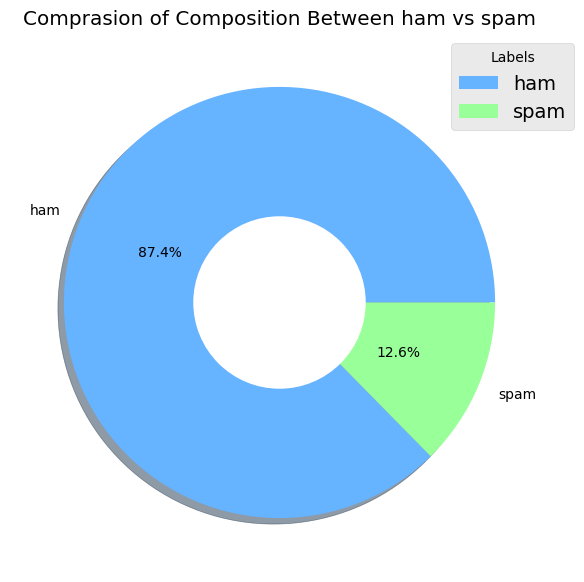

In [ ]:
plt.figure(figsize=(12,7))
plt.pie(df_spam['feature'].value_counts(),
        labels = ['ham', 'spam'],
        autopct = '%0.1f%%',
        colors = ['#66b3ff',
                 '#99ff99'],
        shadow=True)
centre_circle = plt.Circle((0, 0),
                           0.40,
                           fc = 'white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.legend(title='Labels',
           loc='best',
           bbox_to_anchor=(0.8, 1))
plt.title('Comprasion of Composition Between ham vs spam')
plt.show()

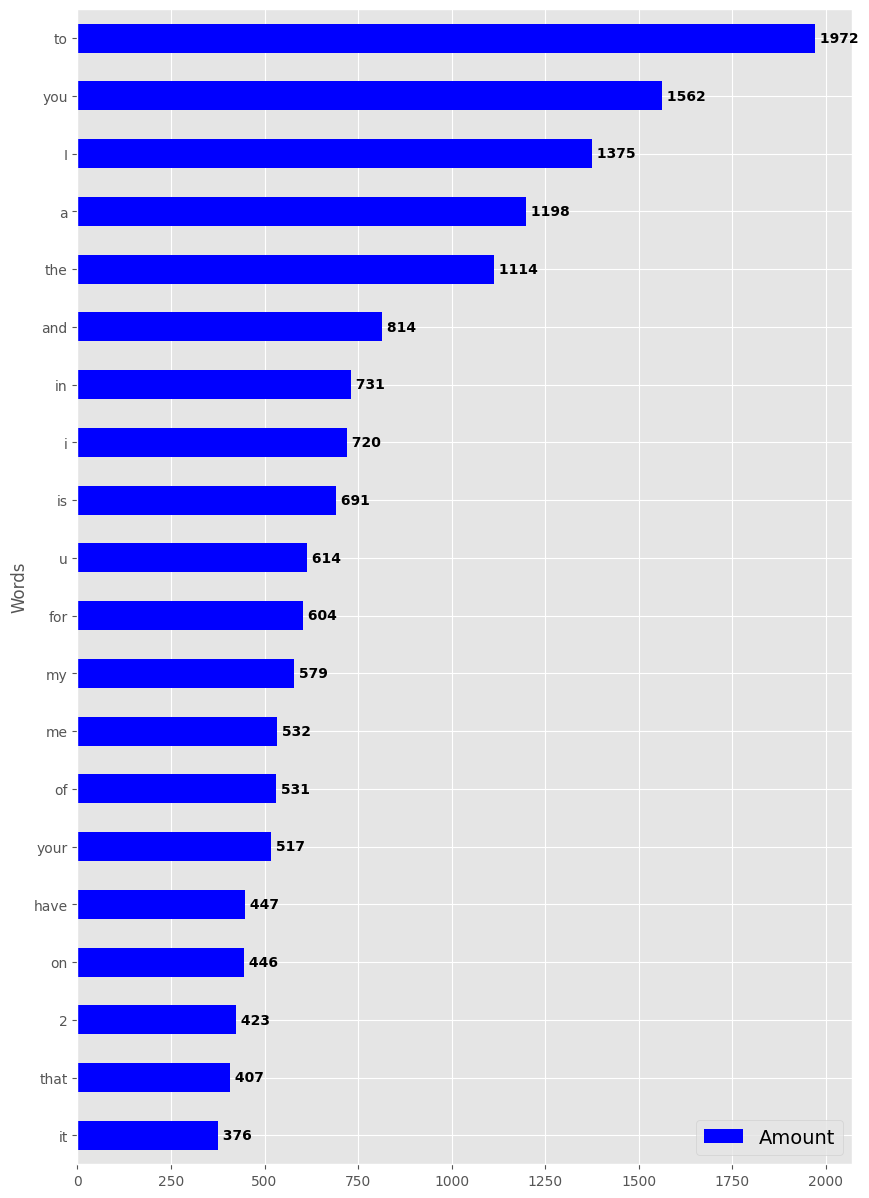

In [ ]:
plot_words(df_spam['message'], number=20)

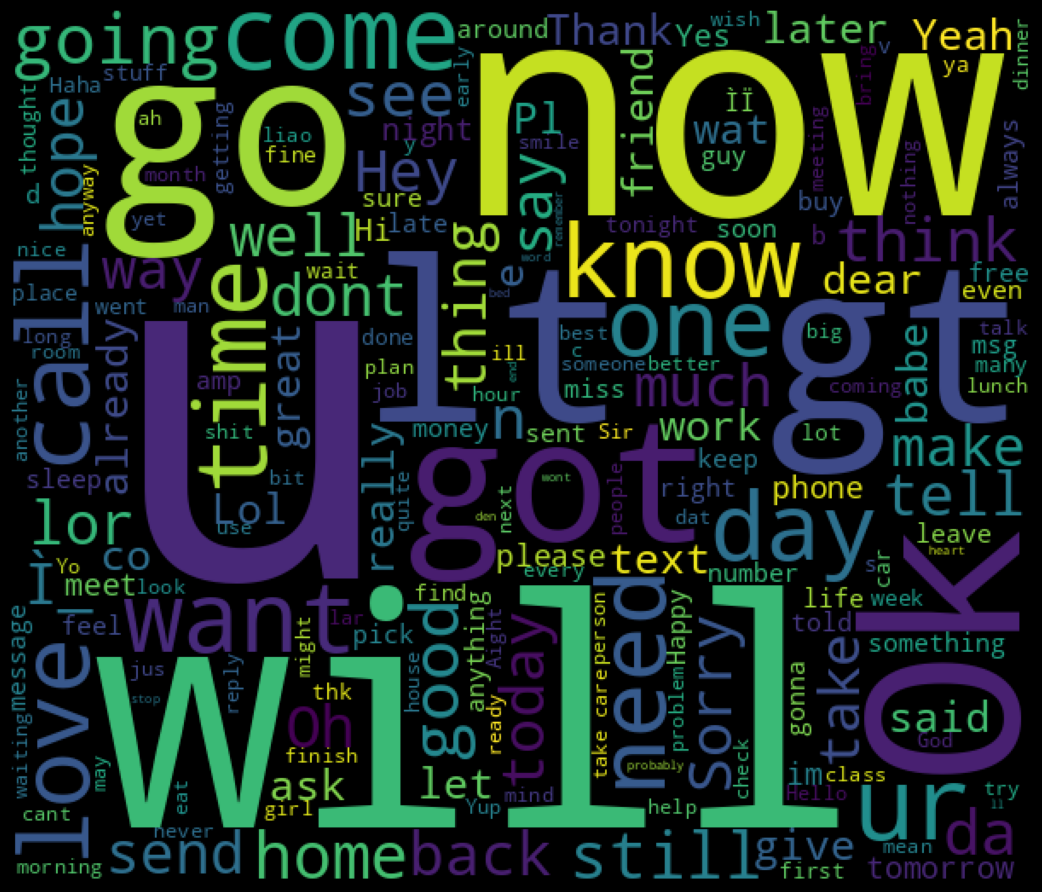

In [ ]:
word_cloud('ham')

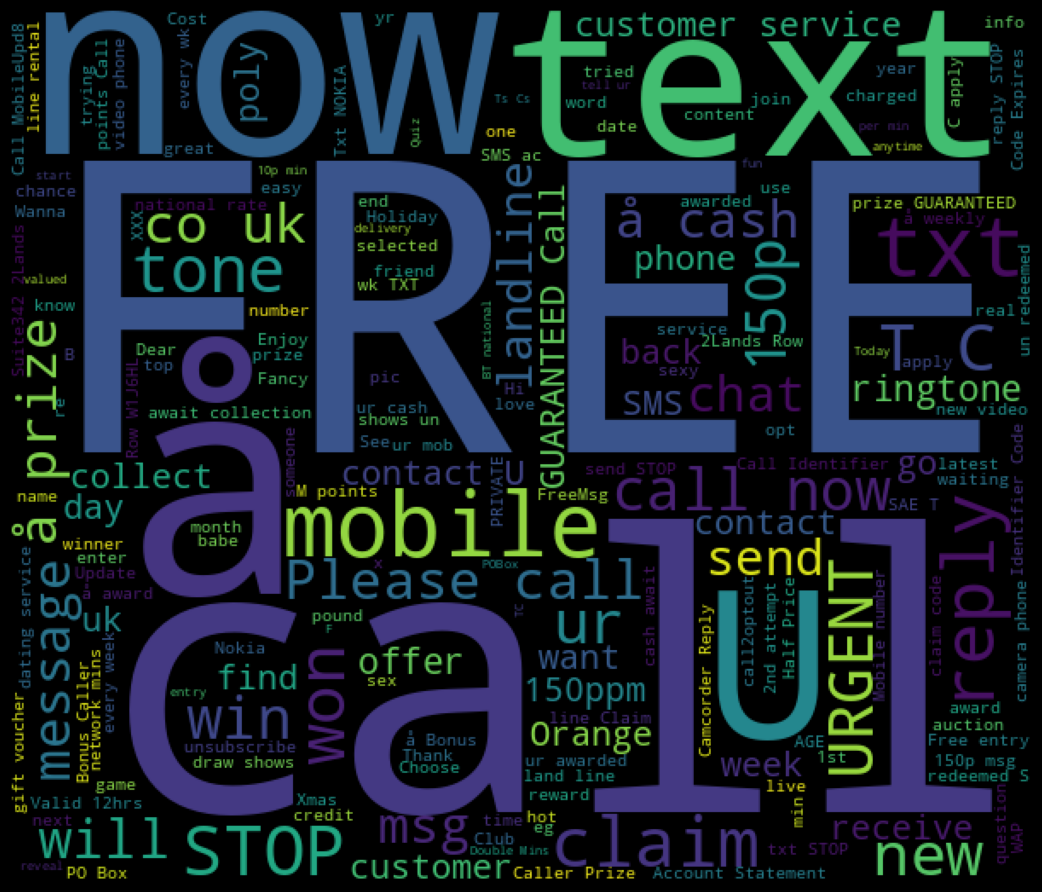

In [ ]:
word_cloud('spam')

In [ ]:
size_vocabulary = 2200
embedding_dimension = 100
trunc_type = 'post'
padding_type = 'post'
threshold = 0.6
oov_token = "OOV"
test_size, valid_size = 0.05, 0.25
num_epochs = 20
drop_level = 0.3

In [ ]:
print("\t\tStage I. Preliminary actions. Preparing of needed sets\n")
full_df_l = []
lemmatizer = WordNetLemmatizer()
for i in range(df_spam.shape[0]):
    mess_1 = df_spam.iloc[i, 1]
    mess_1 = re.sub('\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'emailaddr', mess_1)
    mess_1 = re.sub('(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddr', mess_1)
    mess_1 = re.sub('£|\$', 'moneysymb', mess_1)
    mess_1 = re.sub('\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b', 'phonenumbr', mess_1)
    mess_1 = re.sub('\d+(\.\d+)?', 'numbr', mess_1)
    mess_1 = re.sub('[^\w\d\s]', ' ', mess_1)
    mess_1 = re.sub('[^A-Za-z]', ' ', mess_1).lower()
    token_messages = word_tokenize(mess_1)
    mess = []
    for word in token_messages:
        if word not in set(stopwords.words('english')):
            mess.append(lemmatizer.lemmatize(word))
    txt_mess = " ".join(mess)
    full_df_l.append(txt_mess)

		Stage I. Preliminary actions. Preparing of needed sets



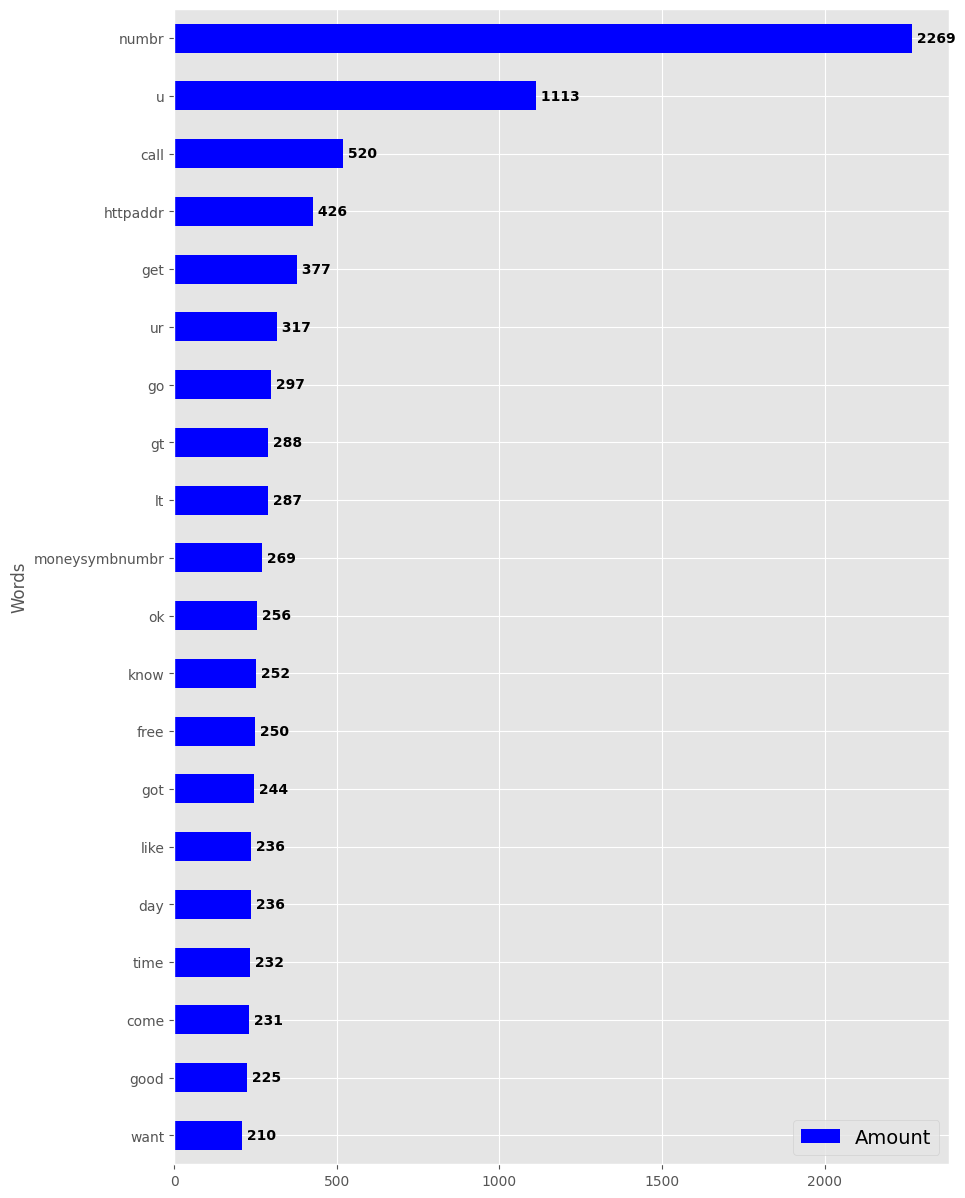

In [ ]:
plot_words(full_df_l, number=20)

**1. Deep Learning**

Untuk Khasus ini, dalam membangun model classification seperti melakukan training set, validation set, dan test set. Model training yang dipakai adalah 70%, validation adalah 25%, dan testing adalah 5%

In [ ]:
print('\t\tStage 1. Preliminary Actions. Preparing of needed sets\n')

kalimat_baru = []
label_baru = []

for i in range(0, df_spam.shape[0], 1):
  kalimat_baru.append(df_spam['message'][i])
  label_baru.append(df_spam['feature'][i])

		Stage 1. Preliminary Actions. Preparing of needed sets



In [ ]:
train_size = int(df_spam.shape[0] * (1 - test_size - valid_size))
valid_bound = int(df_spam.shape[0] * (1 - valid_size))

train_sentences = kalimat_baru[0 : train_size]
valid_sentences = kalimat_baru[train_size : valid_bound]
test_sentences = kalimat_baru[valid_bound :]

train_label_str = label_baru[0 : train_size]
valid_label_str = label_baru[train_size : valid_bound]
test_label_str = label_baru[valid_bound:]

**1. Label Transformations**

In [ ]:
print('\t\tStage 2. Labels Transformations\n')

train_labels = [0] * len(train_label_str)
for ind, item in enumerate(train_label_str):
  if item == 'ham':
    train_labels[ind] = 1
  else:
    train_labels[ind] = 0

valid_labels = [0] * len(valid_label_str)
for ind, item in enumerate(valid_label_str):
  if item == 'ham':
    valid_labels[ind] = 1
  else:
    valid_labels[ind] = 0

test_labels = [0] * len(test_label_str)
for ind, item in enumerate(test_label_str):
  if item == 'ham':
    test_labels[ind] = 1
  else:
    test_labels[ind] = 0


train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)
test_labels = np.array(test_labels)

		Stage 2. Labels Transformations



**2. Tokenization and Data Splitting**

In [ ]:
print('\t\tStage 3. Tokenization\n')

token = Tokenizer(num_words = size_vocabulary,
                  oov_token = oov_token,
                  lower = False)
token.fit_on_texts(train_sentences)
word_index = token.word_index

		Stage 3. Tokenization



In [ ]:
size_voc = len(word_index) + 1

train_sequences = token.texts_to_sequences(train_sentences)
max_len = max([len(i) for i in train_sequences])
train_set = pad_sequences(train_sequences, padding=padding_type, maxlen=max_len, truncating=trunc_type)


valid_sequences = token.texts_to_sequences(valid_sentences)
valid_set = pad_sequences(valid_sequences, padding=padding_type, maxlen=max_len, truncating=trunc_type)

test_sequences = token.texts_to_sequences(test_sentences)
test_set = pad_sequences(test_sequences, padding=padding_type, maxlen=max_len, truncating=trunc_type)

**3. Model Building**

In [ ]:
print('\t\tStage 4. Model Building')

model_LSTM = Sequential([
    Embedding(size_voc, embedding_dimension, input_length=max_len),
    Bidirectional(LSTM(100)),
    Dropout(drop_level),
    Dense(20, activation='relu'),
    Dropout(drop_level),
    Dense(1, activation='sigmoid')
])

		Stage 4. Model Building


In [ ]:
print("\t\tStage 5. Model compiling & fitting\n")
optim = Adam(learning_rate = 0.0001)

model_LSTM.compile(loss = 'binary_crossentropy',
              optimizer = optim,
              metrics = ['accuracy'])
model_LSTM.summary()

		Stage 5. Model compiling & fitting

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 189, 100)          912300    
                                                                 
 bidirectional_13 (Bidirect  (None, 200)               160800    
 ional)                                                          
                                                                 
 dropout_26 (Dropout)        (None, 200)               0         
                                                                 
 dense_26 (Dense)            (None, 20)                4020      
                                                                 
 dropout_27 (Dropout)        (None, 20)                0         
                                                                 
 dense_27 (Dense)            (None, 1)                 21        
               

In [ ]:
history_LSTM = model_LSTM.fit(train_set,
                    train_labels,
                    epochs=num_epochs,
                    validation_data=(valid_set, valid_labels),
                    workers=os.cpu_count(),
                    use_multiprocessing=True,
                    verbose=1)

Epoch 1/20
114/114 [==============================] - 19s 130ms/step - loss: 0.4760 - accuracy: 0.8706 - val_loss: 0.3731 - val_accuracy: 0.8411
Epoch 2/20
114/114 [==============================] - 14s 121ms/step - loss: 0.2797 - accuracy: 0.8731 - val_loss: 0.2747 - val_accuracy: 0.8450
Epoch 3/20
114/114 [==============================] - 14s 123ms/step - loss: 0.2062 - accuracy: 0.9320 - val_loss: 0.1940 - val_accuracy: 0.9419
Epoch 4/20
114/114 [==============================] - 14s 121ms/step - loss: 0.1406 - accuracy: 0.9649 - val_loss: 0.1219 - val_accuracy: 0.9612
Epoch 5/20
114/114 [==============================] - 14s 121ms/step - loss: 0.0930 - accuracy: 0.9751 - val_loss: 0.0970 - val_accuracy: 0.9651
Epoch 6/20
114/114 [==============================] - 14s 122ms/step - loss: 0.0682 - accuracy: 0.9831 - val_loss: 0.1084 - val_accuracy: 0.9574
Epoch 7/20
114/114 [==============================] - 14s 123ms/step - loss: 0.0550 - accuracy: 0.9867 - val_loss: 0.0652 - val_ac

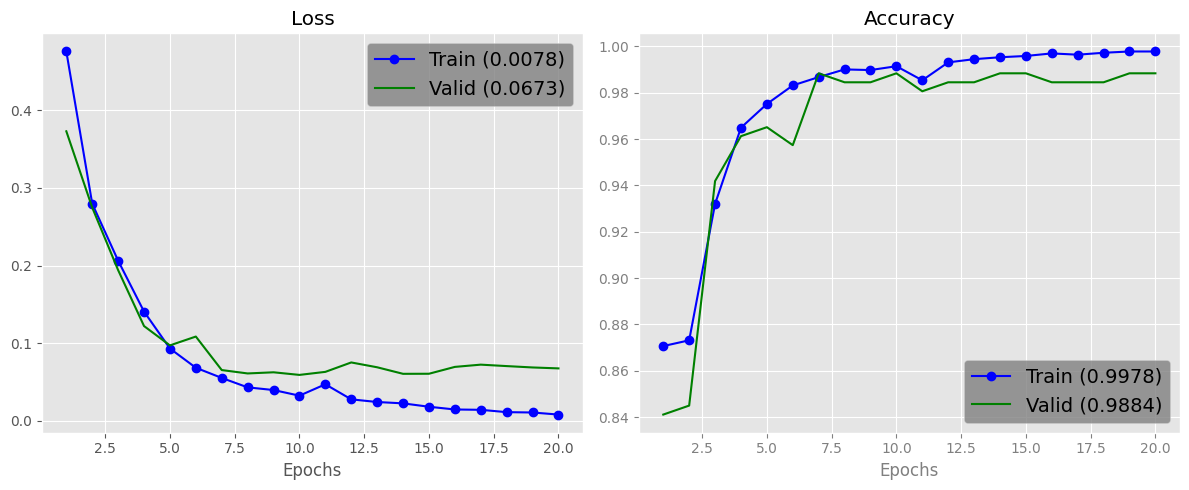

In [ ]:
plot_history(history_LSTM)

In [ ]:
model_score = model_LSTM.evaluate(test_set, test_labels,
                             batch_size=embedding_dimension,
                             verbose=1)
print(f'Test Accuracy: {model_score[1] * 100:0.2f}%\t\t Test Error:{model_score[0]:0.4f}')

13/13 [==============================] - 1s 109ms/step - loss: 0.0670 - accuracy: 0.9838
Test Accuracy: 98.38%		 Test Error:0.0670


In [ ]:
m_name = 'My_model'
pickle.dump(token, open(m_name + '.pkl', 'wb'))
filepath = m_name + '.hs'
tf.keras.models.save_model(model, filepath,
                           include_optimizer=True,
                           save_format='h5',
                           overwrite=True)
print('\t\tSize of The Saved Model:', os.stat(filepath).st_size, 'bytes')

		Size of The Saved Model: 12983264 bytes


In [ ]:
y_pred_LSTM = model_LSTM.predict(test_set)

y_pred = [0] * y_pred_LSTM.shape[0]
for ind, item in enumerate(y_pred_LSTM):
  if item > threshold:
    y_pred[ind] = 1
  else:
    y_pred[ind] = 0

c_m_LSTM = confusion_matrix(test_labels, y_pred)
c_r_LSTM = classification_report(test_labels, y_pred)
print('\t\tClassification Report:\n\n', class_rep_LSTM, '\n')

41/41 [==============================] - 1s 34ms/step
		Classification Report:

               precision    recall  f1-score   support

           0       0.93      0.93      0.93       148
           1       0.99      0.99      0.99      1145

    accuracy                           0.98      1293
   macro avg       0.96      0.96      0.96      1293
weighted avg       0.98      0.98      0.98      1293
 



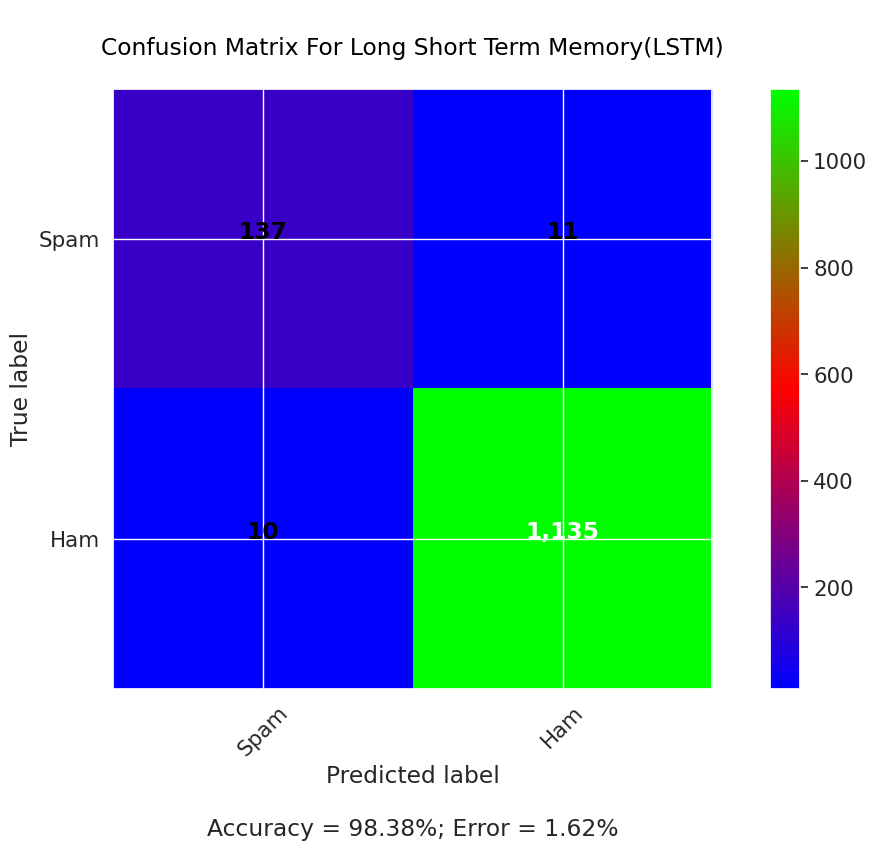

In [ ]:
plot_conf_matr(c_m_LSTM,
               classes=['Spam','Ham'],
               normalize=False,
               cmap=plt.cm.brg,
               title='Confusion Matrix For Long Short Term Memory(LSTM)')

In [ ]:
message_example = ['Darling, Please Give me a Cup of Tea']
message_example_tp = pad_sequences(token.texts_to_sequences(message_example),
                                   maxlen=max_len,
                                   padding=padding_type,
                                   truncating=trunc_type)
pred = float(model_LSTM.predict(message_example_tp))
if (pred > threshold):
  print('This Message is a Real Text')
else:
  print('This Message is a Spam Message')

1/1 [==============================] - 0s 40ms/step
This Message is a Real Text
